# Emotion recognition with RMN
This notebook is for generating saliency maps with the GradCAM method, applied to the RNM (Residual Masking Network) model.

In [1]:
# utils
import torch
import pandas as pd
import seaborn as sns
from torchsummary import summary
from utils.img_functions import *
# rmn
from rmn import *
# gradcam
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

c:\Users\terai\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

Here we load images and create the dataframe with all matching labels. In the dataset used, only four emotions are represented : happiness, sadness, surprise and anger.

In [38]:
csvBV = ".\\datasets\\labels\\BV_labels.csv" # location of BV labels
BVpath = ".\\datasets\\BV" # location of BV images
csvET = ".\\datasets\\labels\\ET_labels.csv" # location of ET labels
ETpath = ".\\datasets\\ET" # location of ET images

## Load dataset
imgs, df_labels = load_all(csvBV,BVpath,csvET,ETpath)

## List relevant emotions
emotions4 = ['happiness','sadness','surprise','anger']

Loaded 200 images successfully
Created dataframe for labels


## ET dataset : load scores of participants

Here we create a separate dataframe for ET images. For each image, if the degree of agreement on the emotion detected is high enough, we also store the expression of the highest scoring class obtained during experiments. If the degree of agreement is too low, value is set to -1 by default.

In [39]:
## Get ET dataset separately
dfET = df_labels.loc[(df_labels['Source']=='BV_ET') | (df_labels['Source']=='ET')]
dfET = dfET.reset_index(drop=True)

## Load scores of participants for all ET images
scores = human_scores_for_all(dfET)

## Sort ET images w.r.t. threshold degree of agreement
threshold = 51.0 # i.e. at least 25 participants must agree on the highest scoring class
dfET = dfET.assign(Human_prediction=-1) # default : -1 if image does not reach threshold
for i in range(scores.shape[0]):
    avg = highest_class_rate(scores[i])
    if avg>=threshold:
        max_idx = np.argmax(scores[i])+1
        match max_idx:
            case 1 : highest_class = 1 # happiness
            case 2 : highest_class = 2 # sadness
            case 3 : highest_class = 3 # surprise
            case 4 : highest_class = 6 # anger
        # store expression of highest scoring class
        dfET.loc[i,'Human_prediction'] = highest_class

# Get images above threshold degree of agreement
dfETabove = dfET.loc[dfET['Human_prediction']>0]
dfETabove = dfETabove.reset_index(drop='True')

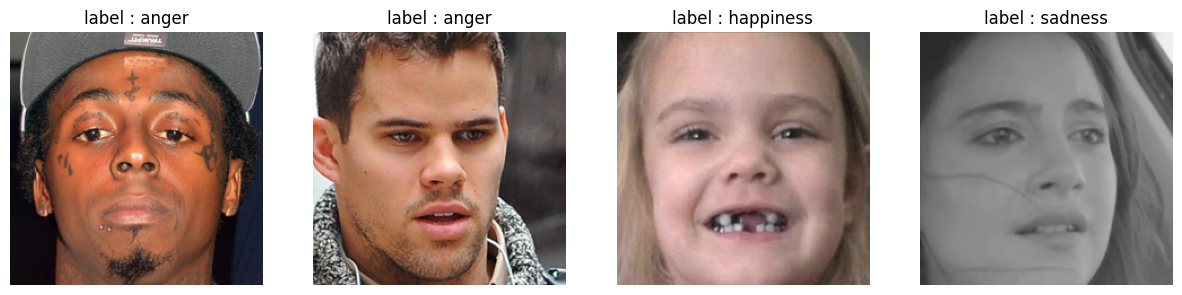

In [3]:
## Display label for four images
plt.figure(figsize=(15,15))
for i in range(4) :
    plt.subplot(1, 4, i + 1)
    im = imgs[i+35]
    label = df_labels['GTEmotion'][i+35]
    plt.title('label : '+label)
    plt.imshow(im)
    plt.axis('off')
plt.show()

# Build FER model

The model used here is called RMN (Residual Masking Network). The implementation was provided by the authors on Github : https://github.com/phamquiluan/ResidualMaskingNetwork. This implementation uses Pytorch.

The model consists of four Residual Masking Blocks. Each one of those blocks contains a residual layer followed by a masking block. Each of those masking blocks is similar to a UNet-network, using pre-trained ResNet34 as backbone. The residual layers are used for feature processing, producing feature maps, and the masking blocks help refine these same feature maps.

The emotions predicted are the following : angry, disgust, fear, happy, sad, surprise, neutral.

Side note : the complete architecture of the model can be found in two versions, in fer-models/rmn directory.

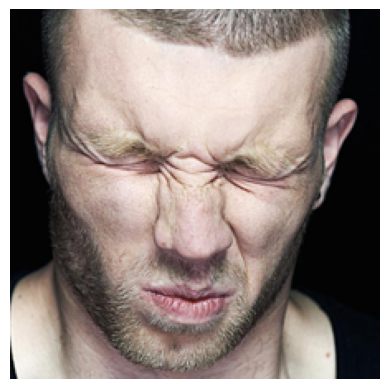

Label: anger
Emotion predicted: angry 0.8371792435646057
Outputs: [{'angry': 0.8371792435646057}, {'disgust': 0.0016244107391685247}, {'fear': 0.00011129738413728774}, {'happy': 0.013521363027393818}, {'sad': 0.13026632368564606}, {'surprise': 0.002716549439355731}, {'neutral': 0.014580780640244484}]
['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc', 'mask1', 'mask2', 'mask3', 'mask4']


In [4]:
# Display a single image
index = 10
im_test = imgs[index]
label_test = df_labels['GTEmotion'][index]
plt.imshow(im_test)
plt.axis('off')
plt.show()

## Build RMN model and get output
def rmn_predict(img):
    predict = RMN()
    result = predict.detect_emotion_for_single_face_image(face_image=img)
    return result

# Display predictions for a single image
emo_label, emo_proba, emo_list = rmn_predict(im_test)
print("Label:",label_test)
print("Emotion predicted:", emo_label, emo_proba)
print("Outputs:",emo_list)

## List predicted emotions
emotions7 = ['happy','sad','surprise','angry','disgust','fear','neutral']

## Build RMN model
model = get_emo_model()
# Print model architecture
# summary(model,input_size=(3,224,224))
# Print main components of model
print([n for n, _ in model.named_children()])

## Display activation maps of target layers

Here we visualize feature maps of specific target layers. It could help select appropriate convolution layers in the RMN model to compute saliency maps.

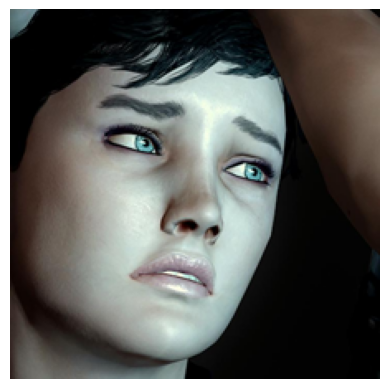

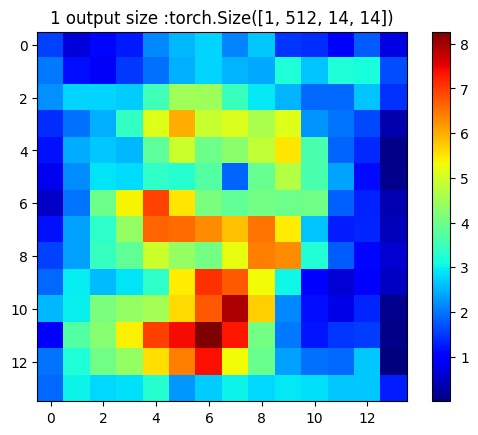

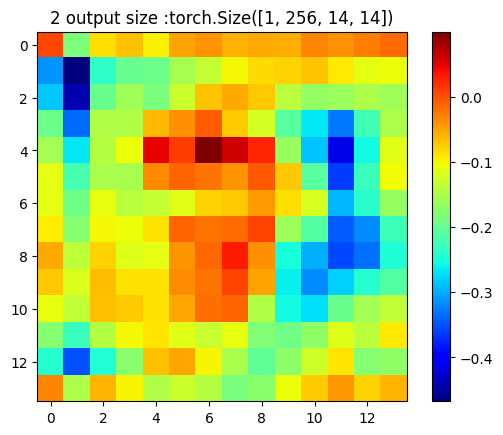

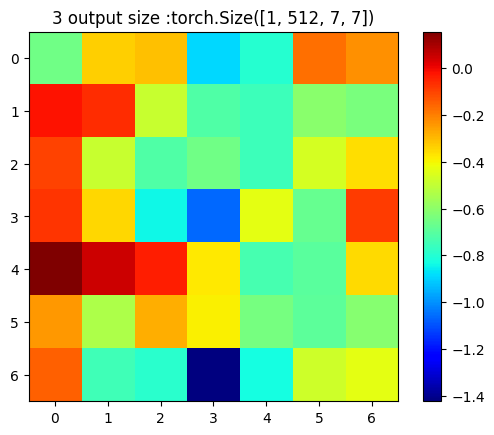

In [14]:
img=imgs[13]
plt.imshow(img)
plt.axis('off')
plt.show()

# preprocess input data
transform = transforms.ToTensor()
input_tensor = transform(img.copy()).unsqueeze(0)

# create dictionary to store activations
activation={}
# define hook to record activations of a given layer
def getActivation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# compute feature maps for selected convolution layers
i=0
layers=[model.mask3.conv1.conv2,model.layer3[-1].conv2,model.layer4[0].conv1] # selected layers
names=[str(i+1) for i in range(len(layers))] # names
for l in layers :
    name=names[i]
    i+=1
    # attach hook to the layer
    h=l.register_forward_hook(getActivation(name))
    # pass input tensor to gpu then forward input in the model
    output = model(input_tensor.cuda())
    # print output dimensions of layer
    # print(name,"output dimensions :",activation[name].shape)
    # pass feature map to cpu then display feature map
    k = 0 # choose feature map number k of the layer
    feature_map = activation[name][0][k].cpu()
    ax = plt.imshow(np.array(feature_map), cmap='jet')
    plt.colorbar(ax)
    plt.title(name+" output size :"+str(activation[name].shape))
    plt.show()
    # release hook
    h.remove()

# Generate GradCAM saliency maps

Here we re-use an existing implementation of GradCAM using PyTorch. Codes can be found on Github : https://github.com/jacobgil/pytorch-grad-cam.

Several CAM methods were implemented by contributors, including GradCAM and GradCAMPlusPlus. Given a deep classification model and an input image, a saliency map can be computed for any selected convolution layer and any selected class.

The selection of the target layer can greatly affect the results obtained in the analysis of the saliency maps.

In [5]:
def compute_gradcam(explainer, model, input_img, target_layer, targets) :

    """
    Parameters :
        explainer : choose GradCAM or GradCAMPlusPlus
        model : pre-trained neural network
        target_layer : convolution layer to compute saliency map for
        targets : target class to compute saliency map for. If targets=None, the highest scoring class is selected by default.
    ------
    Outputs :
        grayscale_cam : saliency map (1 channel)
        visualization : saliency map (3 channels) displayed over original image
    """

    # set transformation parameters
    mean = [0.485, 0.456, 0.406] #[0., 0., 0.]
    std = [0.229, 0.224, 0.225] #[255., 255., 255.]
    normalize_torch = transforms.Normalize(mean,std)
    to_tensor = transforms.ToTensor()
    transform = transforms.Compose([to_tensor,normalize_torch])

    # procede with transformation
    normalized_np = np.float32(input_img) / np.max(input_img)
    input_tensor = to_tensor(normalized_np.copy()).unsqueeze(0)

    # generate explanations
    match explainer :
        case 'GradCAM':
            with GradCAM(model=model, target_layers=target_layer, use_cuda=True) as cam :
                # computing saliency map
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                # overlay heatmap on original input image
                visualization = show_cam_on_image(img=normalized_np, mask=grayscale_cam, use_rgb=True)
        case 'GradCAMPlusPlus':
            with GradCAMPlusPlus(model=model, target_layers=target_layer, use_cuda=True) as cam :
                # computing saliency map
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
                grayscale_cam = grayscale_cam[0, :]
                # overlay heatmap on original input image
                visualization = show_cam_on_image(img=normalized_np, mask=grayscale_cam, use_rgb=True)
        case other:
            print('Invalid explainer')

    return grayscale_cam, visualization

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


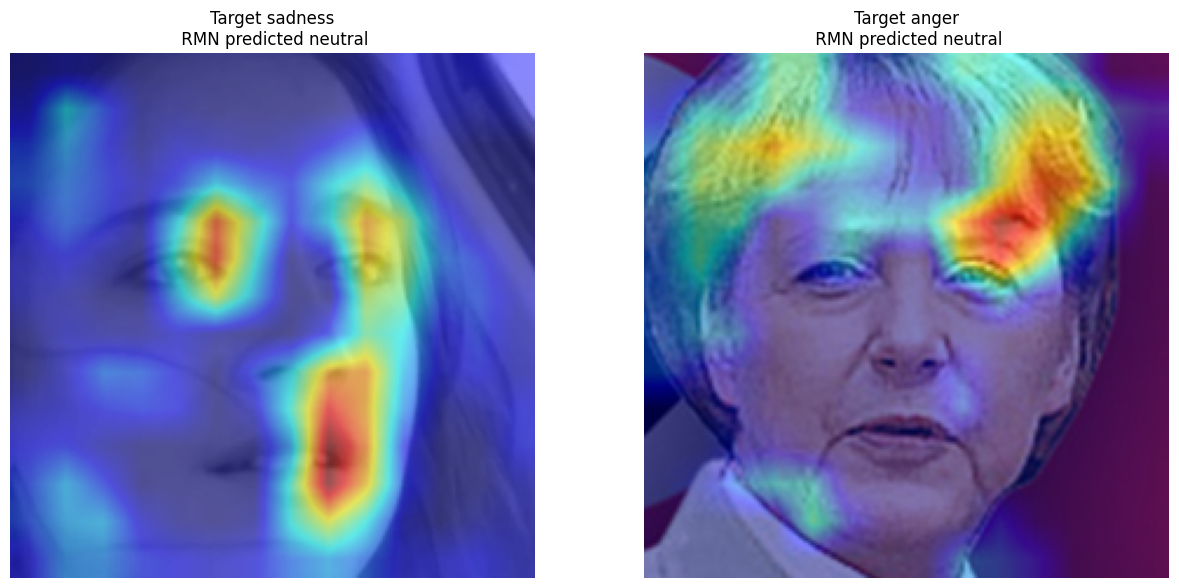

In [35]:
############# Generate examples of explanations #############

# Select target layer and target class
layers = [model.mask3.conv1.conv2]
targets = None

# Plot importance map for several images
pbindxs = [38, 46] # [56, 113, 171, 174]
for name in layers :
    print(name)
    plt.figure(figsize=(15,15))
    for i in range(len(pbindxs)) :
        plt.subplot(2, 2, i + 1)
        idx = pbindxs[i]
        im = imgs[idx]
        label = df_labels['GTEmotion'][idx]
        # generate saliency map
        _ , res2 = compute_gradcam('GradCAM', model, im, [name], targets)
        # generate predictions
        emo_label, emo_proba, _ = rmn_predict(im)
        # plot heatmaps
        plt.title('Target '+label+'\n RMN predicted '+emo_label)
        plt.imshow(res2)
        plt.axis('off')
    plt.show()

In [6]:
def storemaps(arr, target_layers, targets):

    """ store all saliency maps for selected target layer and target class """

    maps = []
    pb_imgs = []
    for i in range(arr.shape[0]) :
        im = arr[i]
        # generate then store saliency map
        res1, _ = compute_gradcam('GradCAM', model, im, target_layers, targets)
        maps.append(res1)
        # find images for which all contributions are negative
        if (np.max(res1)==0.0):
            plt.imshow(im)
            plt.axis('off')
            plt.show()
            pb_imgs.append(im)
    maps = np.array(maps)
    return maps

# Average saliency maps

Here we compute average saliency maps. We can compute the average saliency for all images or the average saliency in each category.

Average saliency map in each category. Here, the category is the associated label.

happiness
mean max 0.6929832562603592  min 0.015809193003967284
sadness
mean max 0.3389554366443513  min 0.05006235816981643
surprise
mean max 0.4128400194732582  min 0.06035295976970719
anger
mean max 0.45563860547111834  min 0.06923536633819408


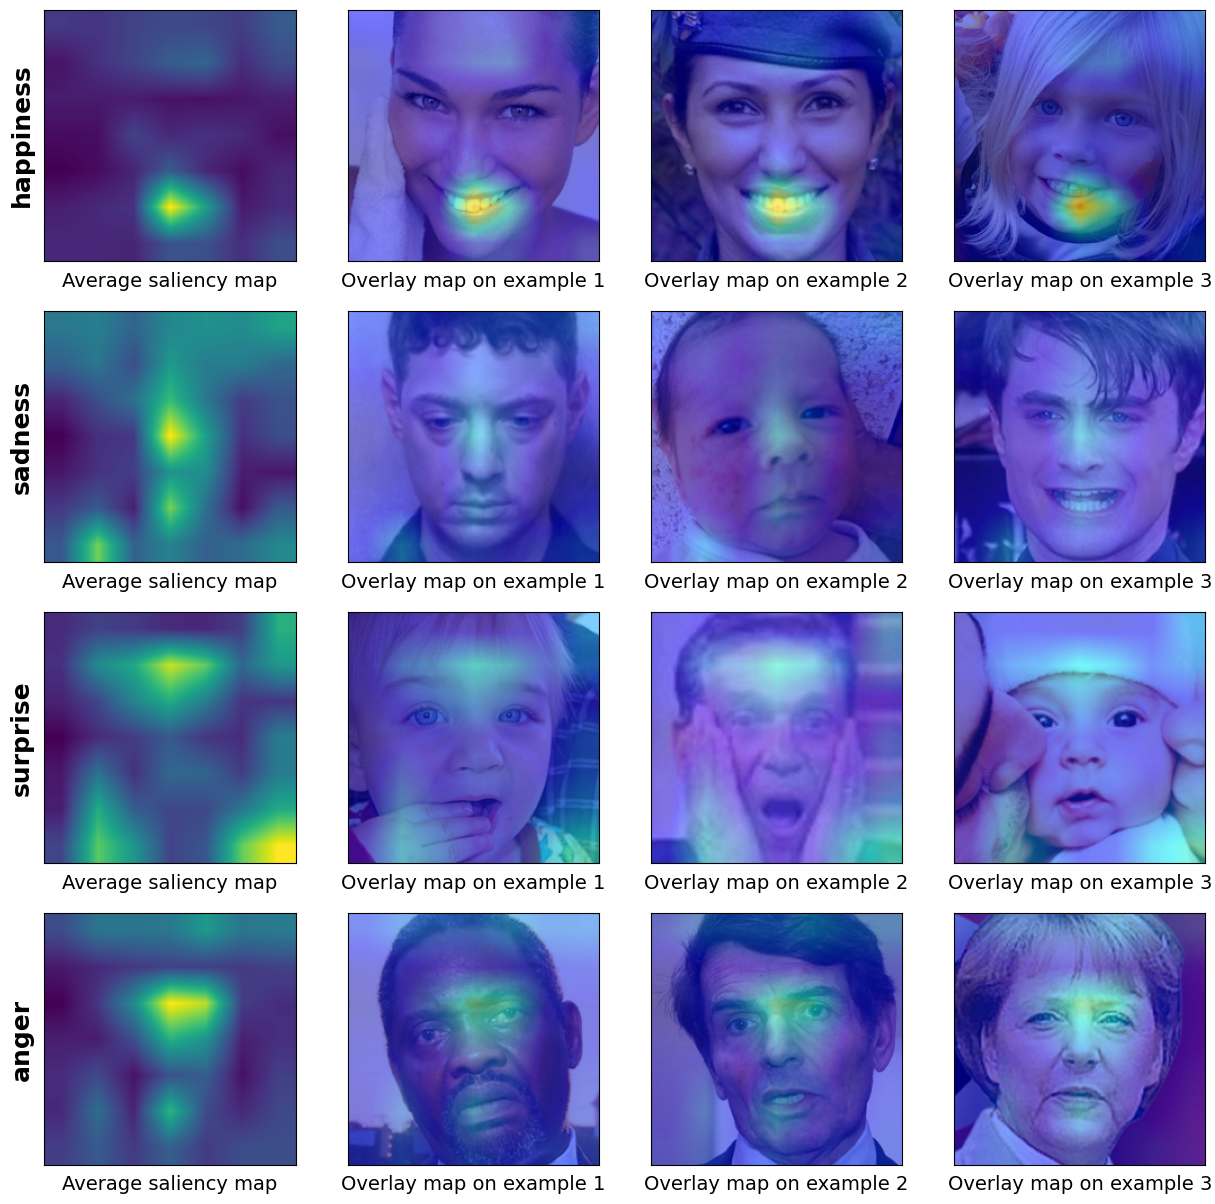

In [61]:
target_layers = [model.layer4[0].conv1]
targets = None

# Separate dataset into four arrays, one array per emotion
groups = group_by_label(imgs,df_labels)

fig, axs = plt.subplots(4,4, figsize=(15,15))
for k in range(len(emotions4)):

    list_k = groups[k]
    print(emotions4[k])

    sum = np.zeros((224,224), dtype=float)
    # Compute gradcam for all images of same emotion
    for im in list_k :
        res1, _ = compute_gradcam('GradCAM', model, im, target_layers, targets)
        sum = sum + res1
    
    # Display averaged saliency
    mean = sum / len(list_k)
    print("mean max",np.max(mean)," min",np.min(mean))
    axs[k,0].imshow(mean)
    axs[k,0].set_xlabel('Average saliency map',fontsize=14)
    axs[k,0].set_ylabel(emotions4[k],fontweight='bold',fontsize=18)
    axs[k,0].set_xticks([])
    axs[k,0].set_yticks([])

    # Display averaged saliency over images
    for i in range(3) :
        im_test = list_k[10+i]
        normalized_np = np.float32(im_test) / np.max(im_test)
        show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
        axs[k,i+1].imshow(show_sum_on_image)
        axs[k,i+1].set_xticks([])
        axs[k,i+1].set_yticks([])
        axs[k,i+1].set_xlabel('Overlay map on example '+str(i+1),fontsize=14)
plt.show()

Average saliency map in each category. Here, the category is the associated RMN prediction.

In [68]:
# Group images by predicted emotion (model prediction)
def group_by_model_predict(imgs, emotions):

    """
    Returns images sorted in lists by prediction (model prediction)
    """
    list = [],[],[],[],[],[],[]
    for i in range(imgs.shape[0]):
        emo_label, _, _ = rmn_predict(imgs[i])
        for k in range (len(emotions)):
            if (emo_label==emotions[k]) :
                list[k].append(imgs[i])
    return list[0], list[1], list[2], list[3], list[4], list[5], list[6]

[43, 24, 46, 44, 12, 8, 23]
happy
mean max 0.7696124846548882  min 0.008900939128199203
sad
mean max 0.2970565947736456  min 3.1117260126241795e-05
surprise
mean max 0.436534958668863  min 0.06767610801166335
angry
mean max 0.6144445517989383  min 0.02741346227817716


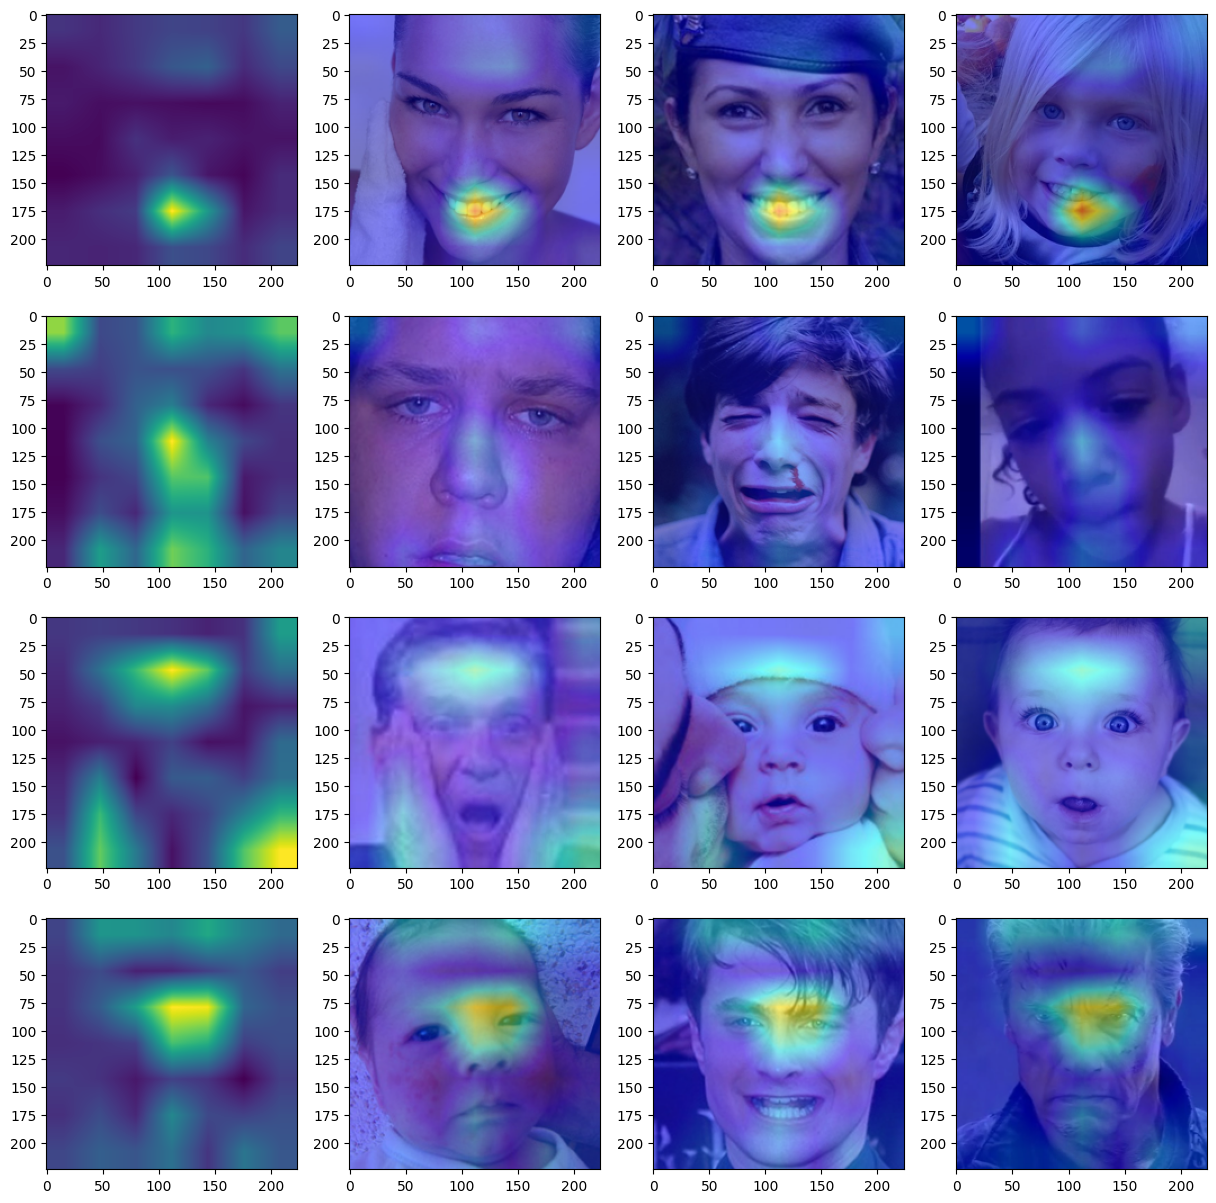

In [70]:
target_layers = [model.layer4[0].conv1]
targets = None

# Sort images by model prediction
groups = group_by_model_predict(imgs, emotions7)
print(get_distribution(groups))

fig, ax = plt.subplots(4,4, figsize=(15,15))
for k in range(4):

    list_k = groups[k]
    print(emotions7[k])

    sum = np.zeros((224,224), dtype=float)
    # Compute gradcam for all images of same emotion
    for im in list_k :
        res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
        sum = sum + res1
    
    # Display averaged saliency
    mean = sum / len(list_k)
    print("mean max",np.max(mean)," min",np.min(mean))
    ax[k,0].imshow(mean)

    # Display averaged saliency over images
    for i in range(3) :
        im_test = list_k[10+i]
        normalized_np = np.float32(im_test) / np.max(im_test)
        show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
        ax[k,i+1].imshow(show_sum_on_image)
plt.show()

Compute weighted average saliency map, weights correspond to model's prediction score (%)

Reminder :
* Model can predict the following emotions : happy, surprise, sad, angry, disgust, fear and neutral.
* Saliency map is computed for highest scoring class in model output.

Computing...
mean max 0.2738773193683947  min 0.03424497609511742


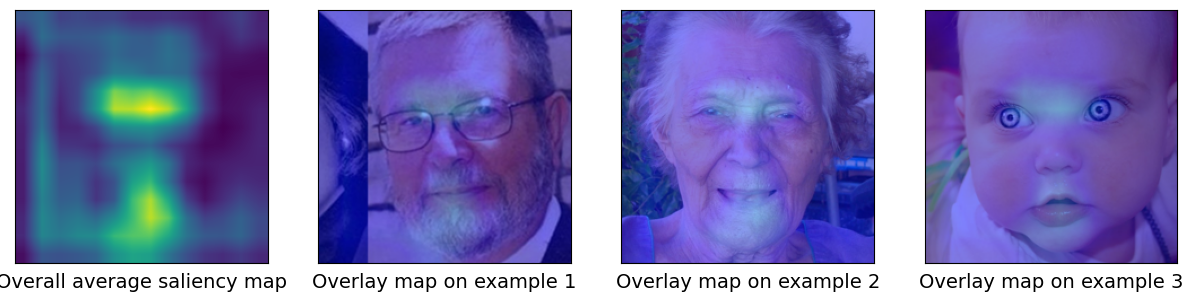

In [25]:
# somme pondérée en fonction de la confiance dans le score prédit par le modèle (%)

target_layers = [model.layer3[-1].conv2]
targets = None

sum = np.zeros((224,224), dtype=float)
sum_proba = 0
i = 0
# Compute weighted gradcam for all images
print("Computing...")
for im in imgs :
    res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
    _ , emo_proba, _ = rmn_predict(im)
    sum = sum + res1*emo_proba
    sum_proba += emo_proba

# Display averaged saliency
mean = sum / sum_proba
print("mean max",np.max(mean)," min",np.min(mean))
fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(mean)
ax[0].set_xlabel('Overall average saliency map',fontsize=14)
ax[0].set_xticks([])
ax[0].set_yticks([])

# Display averaged saliency over images
for i in range(3) :
    im_test = imgs[20+i]
    normalized_np = np.float32(im_test) / np.max(im_test)
    show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
    ax[i+1].imshow(show_sum_on_image)
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_xlabel('Overlay map on example '+str(i+1),fontsize=14)
plt.show()

Compute weighted average saliency map, weights correspond to percentage of participants that voted for the highest scoring class (%)

We compute the average map for ET images that have degree of agreement above the threshold.

Reminder :
* Model can predict emotions the following emotions : happy, surprise, sad, angry, disgust, fear and neutral.
* Humans predicted one of the following emotions : Happiness, Surprise, Sadness and Anger.
* Saliency map is computed for highest scoring class in model output.

mean max 0.42531727753315496  min 0.04751298089268384


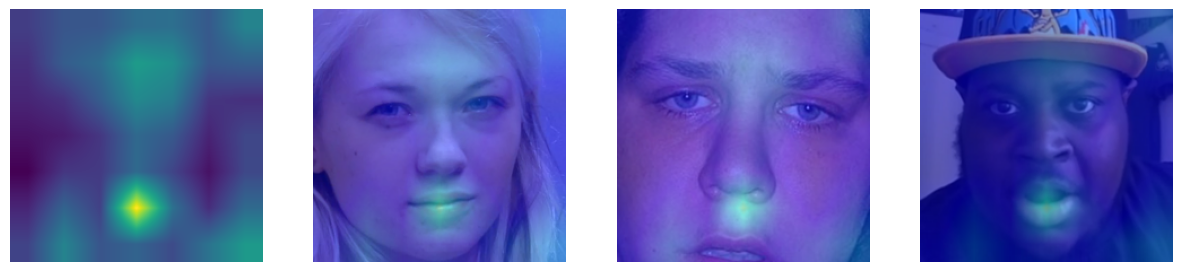

In [60]:
# somme pondérée en fonction des prédictions par les participants (pourcentage de votes)

target_layers = [model.layer4[0].conv1]
targets = None

sum = np.zeros((224,224), dtype=float)
sum_proba = 0
i = 0
# Compute weighted gradcam for ET images above threshold degree of agreement
# imgs contains all images - order of images in imgs matches the order of images in df_labels
index_imgsET = df_labels.loc[df_labels['Source']!='BV'].index
for idx in index_imgsET :
    # find out if degree of agreement on current image is above the threshold
    im = imgs[idx]
    im_name = df_labels['ImageID'][idx]
    index_in_ET = dfET.loc[dfET['ImageID']==im_name].index[0]
    human_pred = dfET['Human_prediction'][index_in_ET]
    if (human_pred!=-1):
        # compute saliency map
        res1, res2 = compute_gradcam('GradCAM', model, im, target_layers, targets)
        # get prediction score
        vote_percent = highest_class_rate(scores[index_in_ET])
        # add current weighted map to sum
        sum = sum + res1*vote_percent
        sum_proba += vote_percent
        i+=1

# Display averaged saliency
mean = sum / sum_proba
print("mean max",np.max(mean)," min",np.min(mean))
fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(mean)
ax[0].set_xlabel('Average saliency map',fontsize=14)
ax[0].axis('off')

# Display averaged saliency over sample images
for i in range(3) :
    im_test = imgs[80+i]
    normalized_np = np.float32(im_test) / np.max(im_test)
    show_sum_on_image = show_cam_on_image(img=normalized_np, mask=mean, use_rgb=True)
    ax[i+1].imshow(show_sum_on_image)
    ax[i+1].set_xlabel('Overlay map on example '+str(i+1),fontsize=14)
    ax[i+1].axis('off')
plt.show()

# Similarities between saliency maps

We use Pearson correlation to evaluate the similarities in every possible pair of saliency maps. We test diverse criterion to group images, then apply Pearson correlation to these groups.

Compute matrix containing Pearson correlation between all images (in pairs)

In [42]:
# Compute correlation coefficients for all pairs of images
def pearsonV1(maps):
    m = np.zeros((maps.shape[0],maps.shape[0]), dtype=float)
    for i in range(maps.shape[0]):
        for j in range(maps.shape[0]):
            x = maps[i,:,:]
            y = maps[j,:,:]
            coefs_1 = np.corrcoef(x.flatten(),y.flatten())
            m[i][j] = coefs_1[0,1]
    return m

def pearsonV2(maps,groups):
    # This version includes white rows and columns to separate categories in the final matrix
    m = np.zeros((maps.shape[0],maps.shape[0]), dtype=float)
    for i in range(maps.shape[0]):
        for j in range(maps.shape[0]):
            x = maps[i,:,:]
            y = maps[j,:,:]
            coefs = np.corrcoef(x.flatten(),y.flatten())
            m[i][j] = coefs[0,1]
    sizes = get_distribution(groups)
    for k in range(1,len(groups)):
        idx = int(np.sum(sizes[:k]))
        # insert column
        m = np.insert(m,[idx],'NaN',axis=1)
        # insert row
        m = np.insert(m,[idx],[['NaN']],axis=0)
    return m

## Generating maps for images

Depending on the settings desired for the matrixes we generate, we reorganize images and regenerate then store their saliency maps.

In [65]:
# Choose target layers and target emotions for computation of saliency maps
target_layers = [model.layer4[0].conv1]
targets = None

# Sort images by label
groups = group_by_label(imgs,df_labels)
imgs_by_label = []
# Images are then stored in a new array
for k in range(4):
    for im in groups[k]:
        imgs_by_label.append(im)
imgs_by_label = np.array(imgs_by_label)

# Sort ET images by label
groups = group_by_label(imgs,dfET)
imgsET_by_label = []
# images are then stored in a new array
for k in range(len(groups)):
    for im in groups[k]:
        imgsET_by_label.append(im)
imgsET_by_label = np.array(imgsET_by_label)

# Sort ET images by human prediction
groups = group_by_human_predict(imgs,dfETabove)
print(len(groups[0]),len(groups[1]),len(groups[2]),len(groups[3]))
# Grouped images are then stored in a single array
imgsA = []
for k in range(4):
    for im in groups[k]:
        imgsA.append(im)
imgsA = np.array(imgsA)

# Store saliency maps for each array considered
mapsV1 = storemaps(imgs, target_layers, targets)
print(mapsV1.shape)
mapsV2 = storemaps(imgs_by_label, target_layers, targets)
print(mapsV2.shape)
mapsV3 = storemaps(imgsET_by_label, target_layers, targets)
print(mapsV3.shape)
mapsV4 = storemaps(imgsA, target_layers, targets)
print(mapsV4.shape)

34 27 33 16
(200, 224, 224)
(200, 224, 224)
(120, 224, 224)
(110, 224, 224)


## Plot matrixes

We plot the corresponding confusion matrixes.

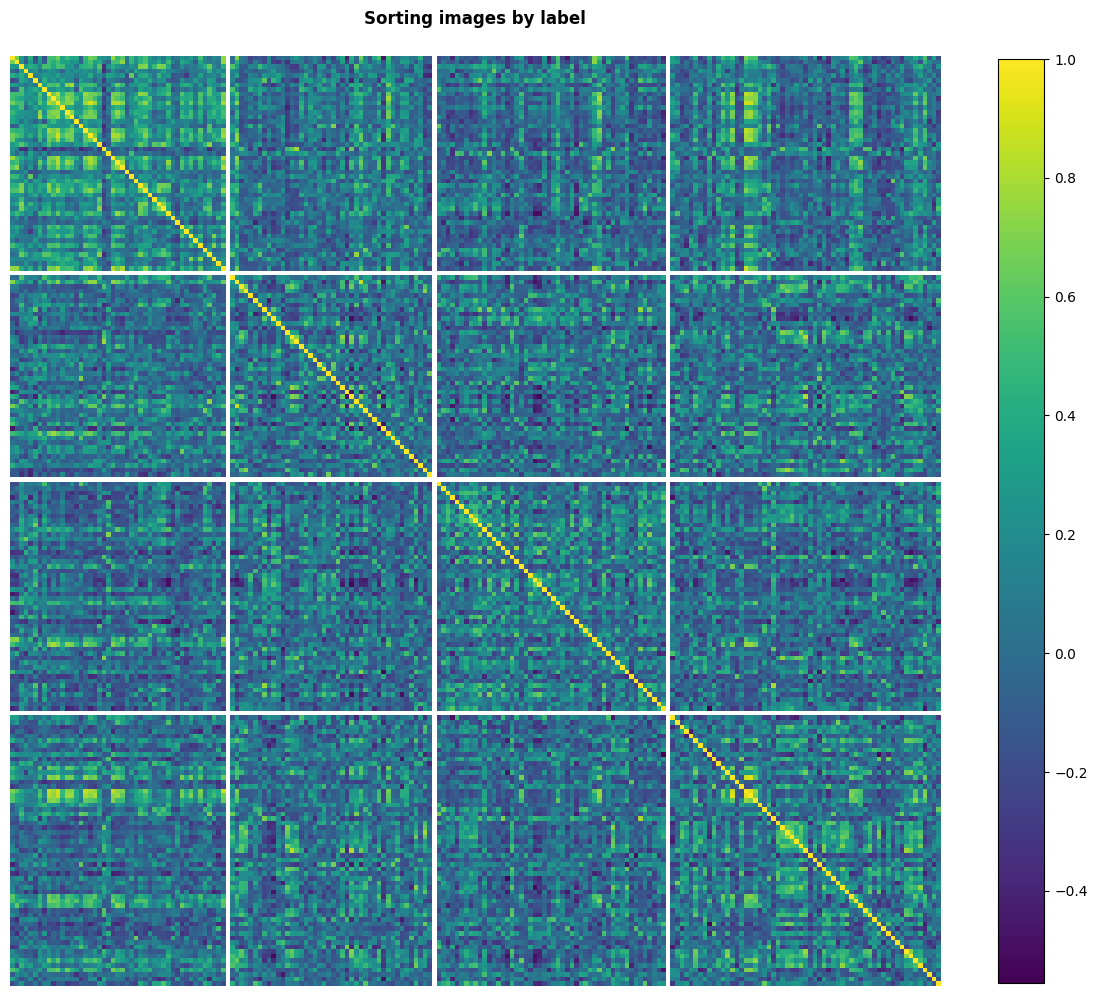

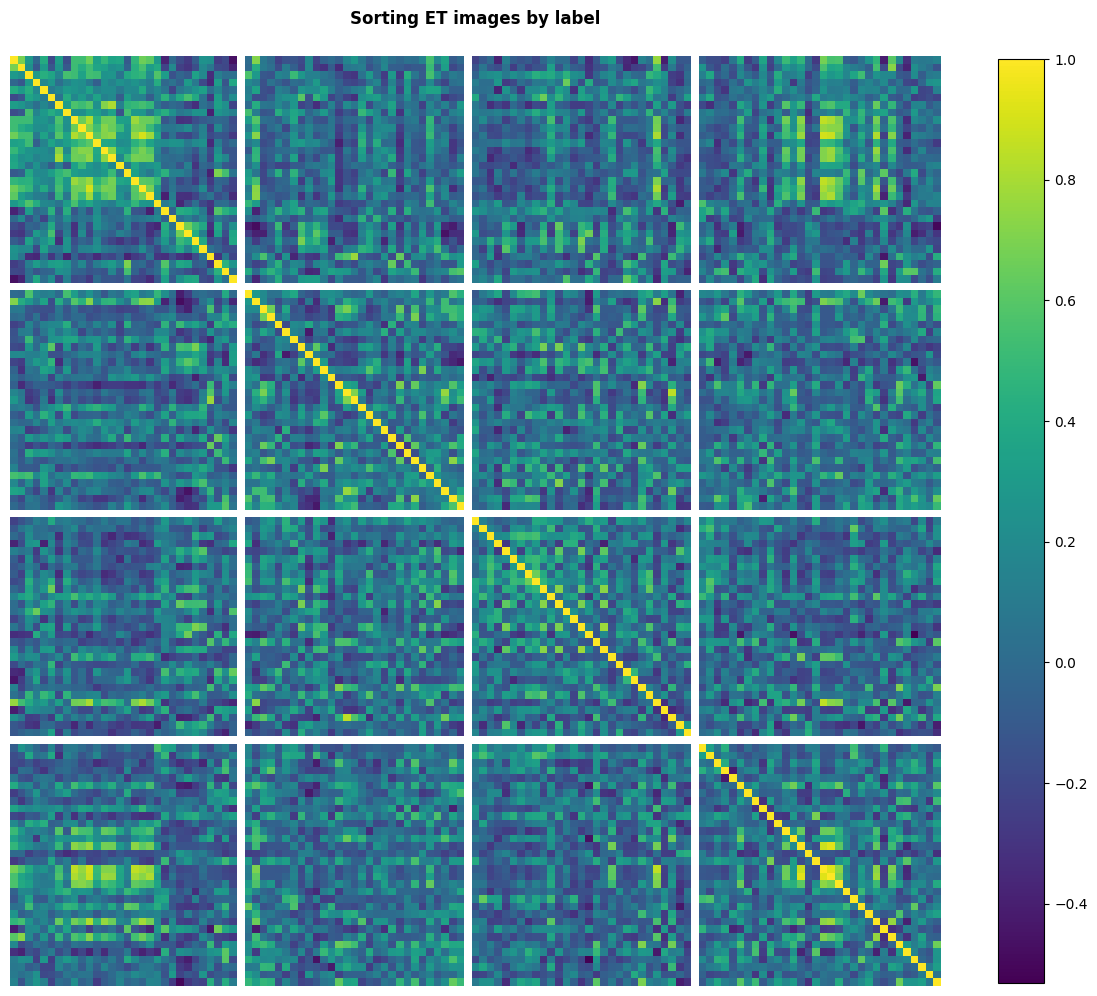

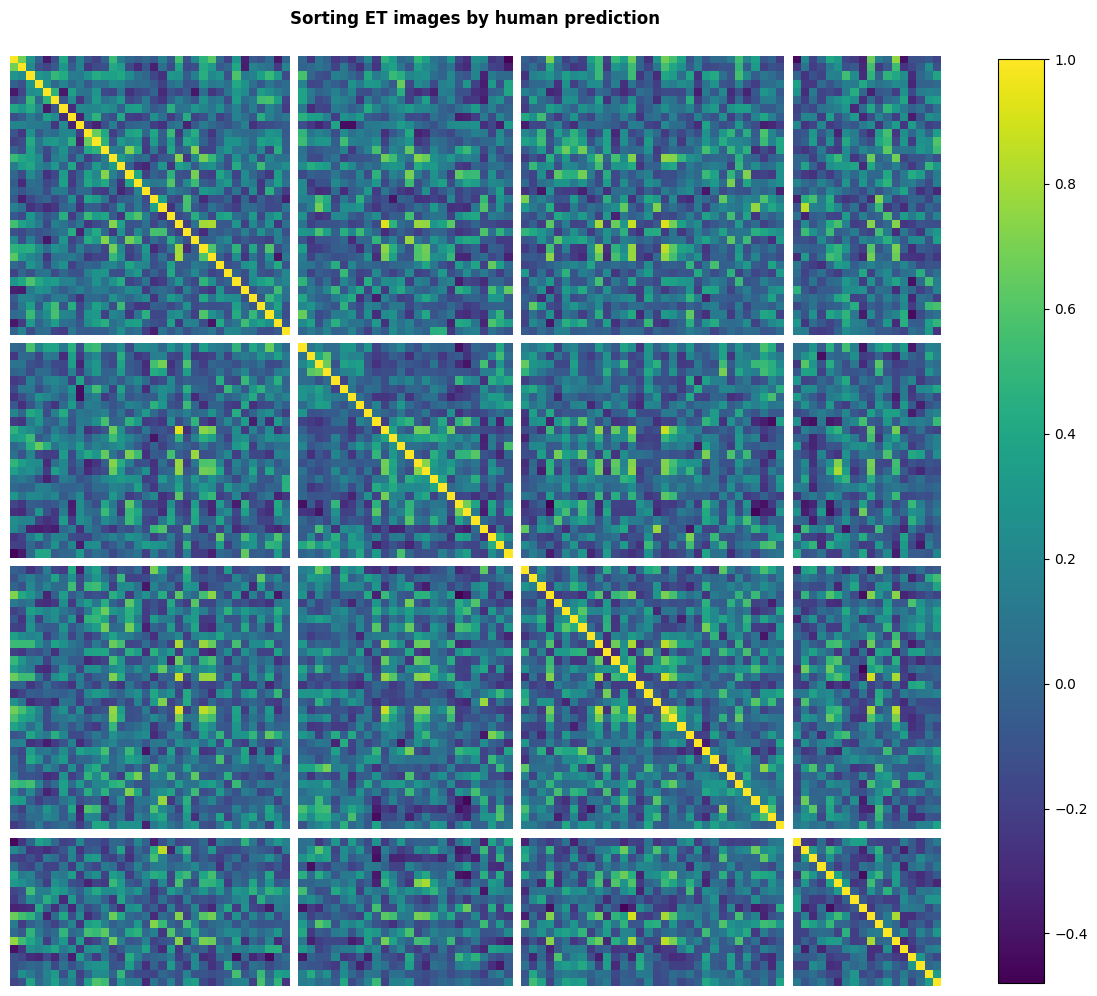

In [66]:
groups = group_by_label(imgs,df_labels)
m = pearsonV2(mapsV2,groups)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sorting images by label', fontweight='semibold')
ax.set_xlabel('happiness     sadness     surprise     anger', fontsize=14)
im = ax.matshow(m)
ax.axis('off')
plt.colorbar(im, ax=ax, shrink=0.8)

groups = group_by_label(imgs,dfET)
m = pearsonV2(mapsV3,groups)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sorting ET images by label', fontweight='semibold')
ax.set_xlabel('happiness     sadness     surprise     anger', fontsize=14)
im = ax.matshow(m)
ax.axis('off')
plt.colorbar(im, ax=ax, shrink=0.8)

groups = group_by_human_predict(imgs,dfETabove)
m = pearsonV2(mapsV4,groups)
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Sorting ET images by human prediction', fontweight='semibold')
ax.set_xlabel('happiness     sadness     surprise     anger', fontsize=14)
im = ax.matshow(m)
ax.axis('off')
plt.colorbar(im, ax=ax, shrink=0.8)